# 이곳에서는
각 영화의 박스오피스 특징을 살펴본다  
특히 초반 흥행, 추반 입소문 영화를 구분하는데에 도전한다

이전 분석에서는 총 관객수와 총 상영주차, 상영횟수는 상관이 없었다.  
현재 분석에서는 총 관객수와 총 상영주차 두 데이터를 사용한다.  
그 이유는 2주차 까지의 데이터가 총 관객수와 큰 차이가 없을 경우 초반 흥행으로 판단할 수 있기 때문이다.  
따라서 최종 분석에서는 2주차 까지의 영화 패턴이랑 예측한 총 관객수 두개를 결합 비교해야 한다.  
총 상영주차는 총 관객수와 상관이 없으므로 예측 모델을 생성할 수 없었다. (그냥 지멋대로라고 생각한다)  
따라서 이거는 영화 데이터의 분포적 특성을 통해 파악할 수 있도록 한다. (이걸 통해 예측을 대체할 수 있을지도)

즉, 해당 분석에서 총 관객수는 사용해도 괜찮다. 최종 분석에서는 2주차 데이터 + 예측 총 관객수 데이터를 사용하기 때문이다 (물론 해당 모델의 신뢰도가 높아야 한다)  
따라서 총 상영주차는 분석의 재료로 사용되어서는 안된다. 분석의 대상이 되어야 한다.

# 라이브러리

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler
import ast
from matplotlib import colormaps
from matplotlib import patches as mpatches
import math

In [ ]:
%load_ext koreanize_matplotlib


The koreanize_matplotlib module is not an IPython extension.


# 데이터

1만명 ~ 500만명 영화만 사용한다  
현재의 분석에선 배우, 감독 장르 벡터는 사용하지 않는다

In [ ]:
data_train = pd.read_csv("../model/model_train_data.csv", encoding="utf-8-sig")
data_test = pd.read_csv("../model/model_test_data.csv", encoding="utf-8-sig")
data_full = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

각 영화의 장르 벡터도 가져온다 (배우, 감독 장르 벡터가 아니다)

In [ ]:
movie_genre = pd.read_csv("../analysis/movie_genre_multi_hot.csv", encoding="utf-8-sig")

In [ ]:
movie_genre.head()

,Movie_Title,genre_multi_hot
0,#살아있다,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,#아이엠히어,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,#위왓치유,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,(여자)아이들 월드투어 [아이돌] 인 시네마,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.0MHz,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
def _ensure_list_of_ints(x):
    """
    genre_multi_hot이 object형(리스트) 또는 문자열('[0,1,0,...]')이어도
    안전하게 정수 리스트로 변환
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    if isinstance(x, list):
        return [int(v) for v in x]
    if isinstance(x, np.ndarray):
        return [int(v) for v in x.tolist()]
    if isinstance(x, str):
        s = x.strip()
        try:
            arr = ast.literal_eval(s)  # '[0,1,0]' → [0,1,0]
            return [int(v) for v in arr]
        except Exception:
            # '0,1,0' 같은 형태 대비
            s = s.strip("[]")
            parts = [p.strip() for p in s.split(",") if p.strip() != ""]
            return [int(float(p)) for p in parts]
    # 그 외 타입은 실패 처리
    raise ValueError(f"genre_multi_hot 값을 리스트로 변환할 수 없습니다: {x}")

In [ ]:
genre_vector = pd.DataFrame(list(movie_genre["genre_multi_hot"].apply(_ensure_list_of_ints)), columns=['드라마', '멜로/로맨스', '다큐멘터리', '공연', '공포(호러)', '액션', '애니메이션', '코미디', '스릴러', 'SF', '미스터리', '어드벤처', '범죄', '판타지', '전쟁', '가족', '사극', '뮤지컬'])
genre_vector.head(2)

,드라마,멜로/로맨스,다큐멘터리,공연,공포(호러),액션,애니메이션,코미디,스릴러,SF,미스터리,어드벤처,범죄,판타지,전쟁,가족,사극,뮤지컬
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_genre = pd.concat([movie_genre[['Movie_Title']], genre_vector], axis=1)

줄거리 임베딩 벡터는 사용하지 않는다

In [ ]:
embedding_list = [f"e{i}" for i in range(1, 256+1)]
data_full.drop(columns=embedding_list, inplace=True)

In [ ]:
data_full.drop(columns=["Total_Show_Days"], inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)
data_full.head(2)

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade,Main_Country
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.50,288.00,230.5,18.5,786.574025,2022,1,1,0.0,1.0,0.0,0.0,15세이상관람가,일본
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.25,835.75,6152.5,207.0,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,전체관람가,기타


grade, main country 원핫인코딩

In [ ]:
make_dummies_cols = ["Grade", "Main_Country"]
data_full = pd.get_dummies(data_full, columns=make_dummies_cols, drop_first=True)
one_hot_cols = [col for col in data_full.columns if col.startswith("Grade_") or col.startswith("Main_Country_")]
data_full[one_hot_cols] = data_full[one_hot_cols].astype("int8")
data_full.head(2)

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.50,288.00,230.5,18.5,786.574025,2022,1,1,0.0,1.0,0.0,0.0,1,0,0,0,1,0
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.25,835.75,6152.5,207.0,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0


박스오피스 데이터랑 장르 벡터랑 결합

In [ ]:
data_full = pd.merge(data_full, movie_genre, how="left", on="Movie_Title")

In [ ]:
movie_title = data_full[["Movie_Title"]].copy()
movie_data = data_full.drop(columns=["Movie_Title"]).copy()

# 관객수 비교

## 1) 영화 흥행 유형 구분

### 변수 생성

In [ ]:
temp1 = movie_data[["Total_Audience_Count", "wk1_Audience", "wk2_Audience"]].copy()
temp1.loc[:,"con_wk2"] = temp1["wk1_Audience"] + temp1["wk2_Audience"]
temp1.loc[:,"wk1_wk2"] = round((temp1["con_wk2"]/temp1["wk1_Audience"]-1)*100, 2)
temp1.loc[:,"wk2_total"] = round((temp1["Total_Audience_Count"]/temp1["con_wk2"]-1)*100, 2)

`wk1_wk2` : 1주차와 2주차의 관객수 변화율(백분율)  
`wk2_total` : 2주차와 총 관객수의 변화율(백분율)  

이제 이걸 통해 초반 흥행과 후반 흥행을 분류할 수 있는지 확인한다

In [ ]:
cluster_1 = temp1[["wk1_wk2", "wk2_total"]].copy()
cluster_1.describe()

,wk1_wk2,wk2_total
count,2568.000000,2568.000000
mean,75.819206,42.726908
std,51.384244,247.551834
min,2.730000,0.000000
25%,42.912500,6.485000
50%,64.820000,17.135000
75%,95.305000,42.582500
max,718.180000,11595.360000


`ratio` : `wk1_wk2`와 `wk2_total`의 비율
이것으로 초반 오픈형인지, 후반 입소문형인지, 균형형인지 구분한다

In [ ]:
cluster_1.loc[:,"ratio"] = cluster_1["wk2_total"]/cluster_1["wk1_wk2"]

`diff`값이 크면 초반 주차에 후반 주차보다 관객이 많이 몰렸다는 것이다

<Axes: xlabel='ratio', ylabel='Count'>

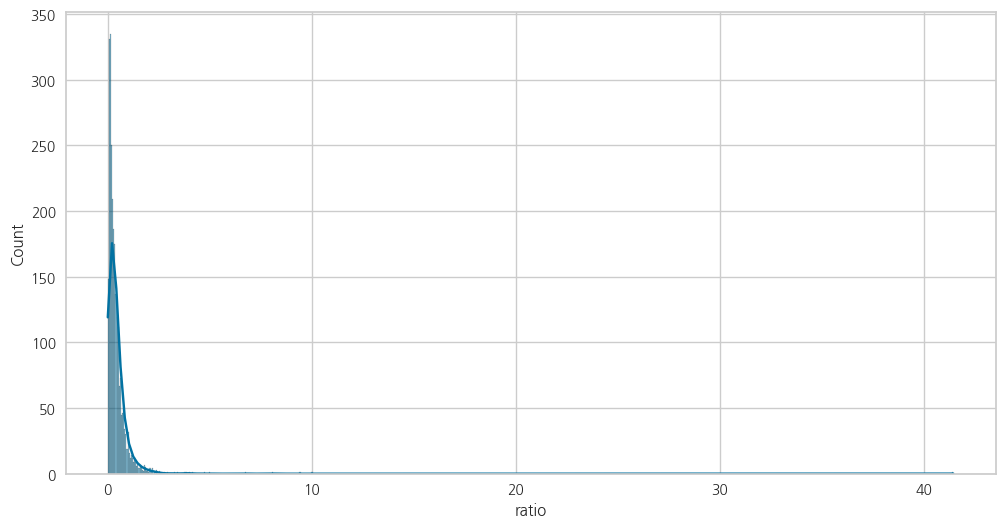

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(cluster_1['ratio'], kde=True)

### 이상치 탐지

{'whiskers': [<matplotlib.lines.Line2D at 0x3099882d0>,
 'caps': [<matplotlib.lines.Line2D at 0x309988550>,
 'boxes': [<matplotlib.lines.Line2D at 0x309988190>],
 'medians': [<matplotlib.lines.Line2D at 0x3099887d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x309988910>],
 'means': []}

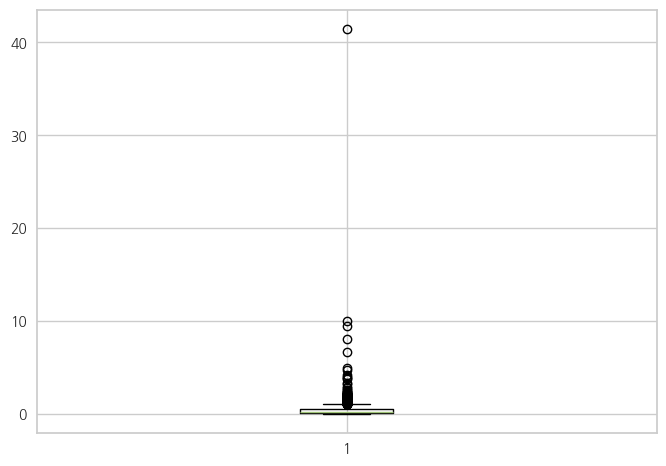

In [ ]:
plt.boxplot(cluster_1['ratio'])

<Axes: xlabel='ratio', ylabel='Count'>

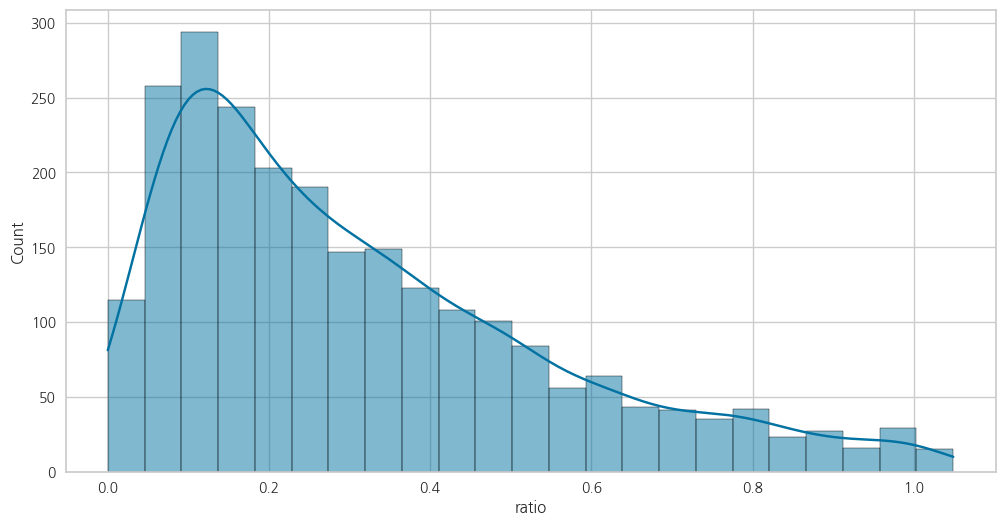

In [ ]:
#박스플롯 기준 이상치 탐지
def find_outliers_iqr(data_series):
    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data_series < lower_bound) | (data_series > upper_bound)

is_outlier = cluster_1[['ratio']].apply(find_outliers_iqr)

cluster_1_box = cluster_1[~is_outlier['ratio']].copy()
plt.figure(figsize=(12, 6))
sns.histplot(cluster_1_box['ratio'], kde=True)

사실 2주차 까지와 2주차 ~ 상영종료일까지의 간격은 클수밖에 없다. 따라서 박스플롯으로 이상치 제거는 하지 않는것이 좋을 것 같다 (이상치같지만 이상치가 아니다)

In [ ]:
cluster_1['ratio'].describe()

count    2568.000000
mean        0.422740
std         0.971192
min         0.000000
25%         0.132043
50%         0.270109
75%         0.499638
max        41.441601
Name: ratio, dtype: float64

### 영화 흥행 유형

백분위수를 통해 구분한다

In [ ]:
# 33, 66 백분위수 계산
p33 = cluster_1['ratio'].quantile(0.33)
p66 = cluster_1['ratio'].quantile(0.66)

print(f"33백분위수 (하위 그룹 경계): {p33:.2f}")
print(f"66백분위수 (상위 그룹 경계): {p66:.2f}")

33백분위수 (하위 그룹 경계): 0.17
66백분위수 (상위 그룹 경계): 0.40


In [ ]:
percentile_lt = (cluster_1['ratio'] < 1).mean() * 100
print(f"ratio < 1인 경우 백분위수: {percentile_lt:.2f}")

ratio < 1인 경우 백분위수: 93.03


1. 초반 폭발형 : 66분위수보다 아래
2. 중반 균형형 : 66분위수 ~ ratio < 1
4. 후반 입소문형 : ratio >= 1

In [ ]:
def classify_ratio(ratio):
    if ratio < p66:
        return '초반 폭발형'
    elif p66 <= ratio < 1:
        return '중반 균형형'
    else:
        return '후반 입소문형'

cluster_1['hit_category'] = cluster_1['ratio'].apply(classify_ratio)

In [ ]:
cluster_1.tail()

,wk1_wk2,wk2_total,ratio,hit_category
2563,133.77,78.29,0.585258,중반 균형형
2564,12.47,22.57,1.809944,후반 입소문형
2565,58.13,12.23,0.210391,초반 폭발형
2566,107.95,122.33,1.133210,후반 입소문형
2567,65.57,23.64,0.360531,초반 폭발형


원핫인코딩

In [ ]:
temp = cluster_1[["hit_category"]].copy()
temp = pd.get_dummies(temp, columns=["hit_category"], drop_first=True)
one_hot_cols = [col for col in temp.columns if col.startswith("hit_category_")]
temp[one_hot_cols] = temp[one_hot_cols].astype("int8")
temp.tail()

,hit_category_초반 폭발형,hit_category_후반 입소문형
2563,0,0
2564,0,1
2565,1,0
2566,0,1
2567,1,0


In [ ]:
data_full = pd.concat([data_full, temp], axis=1)

In [ ]:
data_full.head()

,Movie_Title,Total_Audience_Count,Total_Weeks,wk1_Audience,wk1_AudiencePerShow,wk2_Audience,wk2_AudiencePerShow,Show_Change,opening_Ho_Retention,wk1_Holiday_AudienceMean,wk1_Holiday_ShowMean,wk2_Holiday_AudienceMean,wk2_Holiday_ShowMean,opening_AudienceStd,Year,Month,Pandemic,dist_big_flop,dist_big_hit,dist_small_flop,dist_small_hit,Grade_15세이상관람가,Grade_전체관람가,Grade_청소년관람불가,Main_Country_미국,Main_Country_일본,Main_Country_한국,드라마,멜로/로맨스,다큐멘터리,공연,공포(호러),액션,애니메이션,코미디,스릴러,SF,미스터리,어드벤처,범죄,판타지,전쟁,가족,사극,뮤지컬,hit_category_초반 폭발형,hit_category_후반 입소문형
0,도쿄 리벤저스,13122,8,8617.0,5.654199,2925,5.034423,0.381234,0.130780,1762.500000,288.00,230.500000,18.500000,786.574025,2022,1,1,0.0,1.0,0.0,0.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,매직브러시,169106,8,145560.0,37.670807,18117,14.717303,0.318582,0.182869,33644.250000,835.75,6152.500000,207.000000,19587.819778,2016,5,0,1.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,숨바꼭질,656089,8,195760.0,92.645528,307980,65.807692,2.214860,0.892172,72350.000000,708.00,64548.666667,689.333333,21173.653550,2005,2,0,0.0,1.0,0.0,0.0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,해빙,1201576,9,906864.0,44.818820,232306,13.362439,0.859197,0.189943,242744.333333,4170.00,46107.500000,1973.500000,106514.990773,2017,3,0,0.0,1.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,"다시, 봄",25506,4,18609.0,5.126446,3969,3.598368,0.303857,0.028099,3897.000000,656.00,109.500000,9.500000,1733.336745,2019,4,0,0.0,1.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## 2) 탐색적 요인분석

In [ ]:
data_fa = data_full.drop(columns=["Movie_Title"], axis=1).copy()

원핫인코딩 범주형 변수, month는 표준화를 하지 않는다  
month는 sin, cos변환하여 계절적 순환 구조를 보존한 후 표준화를 진행

# hit category랑 다른 변수 유의성 검정, ANOVA

## 만약 유의하다면 hit category를 예측한 다음(여기엔 총 관객수가 사용되지 않은, 2주차까지의 데이터만 이용해서), 관객수 예측 또는 총 상영주차 예측에 사용할 수 있지 않을까

근데 1,2주차, 총 관객수를 이용해 hit catefgory를 만들었는데, 이걸 이용해 다시 총 관객수를 예측하는게 맞나?